In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from pprint import pprint

# scraping modules
from requests import get
from bs4 import BeautifulSoup

import unicodedata
import re
import json

from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

import acquire
import og_acquire
import prepare

In [2]:
plt.rc('figure', figsize=(16,8))
plt.rc('font', size=14)
sns.set_palette('pastel')

In [3]:
df = prepare.wrangle_readme_data()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 4 columns):
repo                     270 non-null object
language                 238 non-null object
readme_contents          270 non-null object
clean_readme_contents    270 non-null object
dtypes: object(4)
memory usage: 8.6+ KB


In [5]:
df.head()

,repo,language,readme_contents,clean_readme_contents
0,jtleek/datasharing,None,How to share data with a statistician\n=======...,share data statistician guide anyone need shar...
1,rdpeng/ProgrammingAssignment2,R,### Introduction\n\nThis second programming as...,introduction second programming assignment req...
2,octocat/Spoon-Knife,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...
3,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www....",div aligncenter img srchttpswwwtensorfloworgim...
4,SmartThingsCommunity/SmartThingsPublic,Groovy,# SmartThings Public GitHub Repo\n\nAn officia...,smartthings public github repo official list s...


## Distribution of languages used

In [6]:
df_lang_count = pd.DataFrame(df.language.value_counts())

Total Observations

In [7]:
# 238 total observation
df_lang_count.sum()

language    238
dtype: int64

Seems a bit sparse on some of the languages with less than 5 projects done in that language, deciding to lop all of the languages less than 5 into an other bin 

In [8]:
df_lang_count

,language
JavaScript,54
Java,36
Python,28
C++,16
HTML,14
Jupyter Notebook,13
C,10
Go,10
PHP,9
TypeScript,9


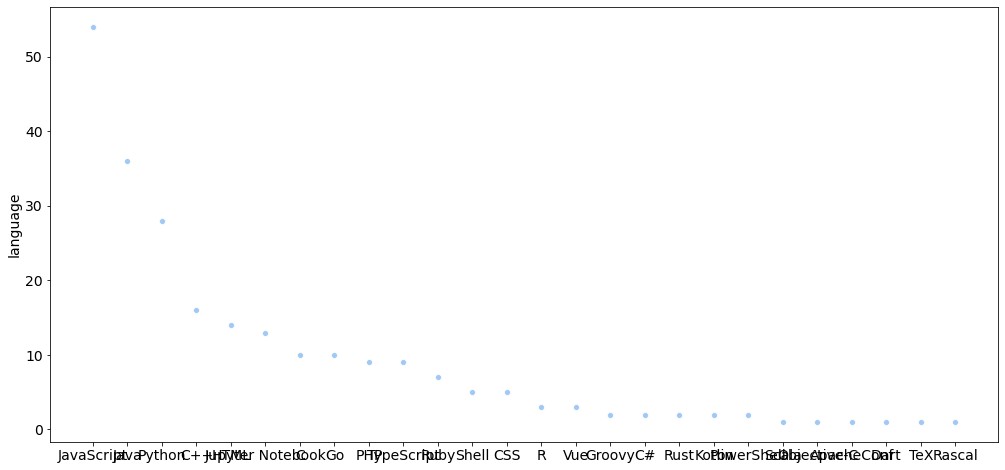

In [9]:
plt.figure(figsize=(17,8))
x = df_lang_count.index
y = df_lang_count.language
sns.scatterplot(data=df_lang_count, x=x, y=y)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

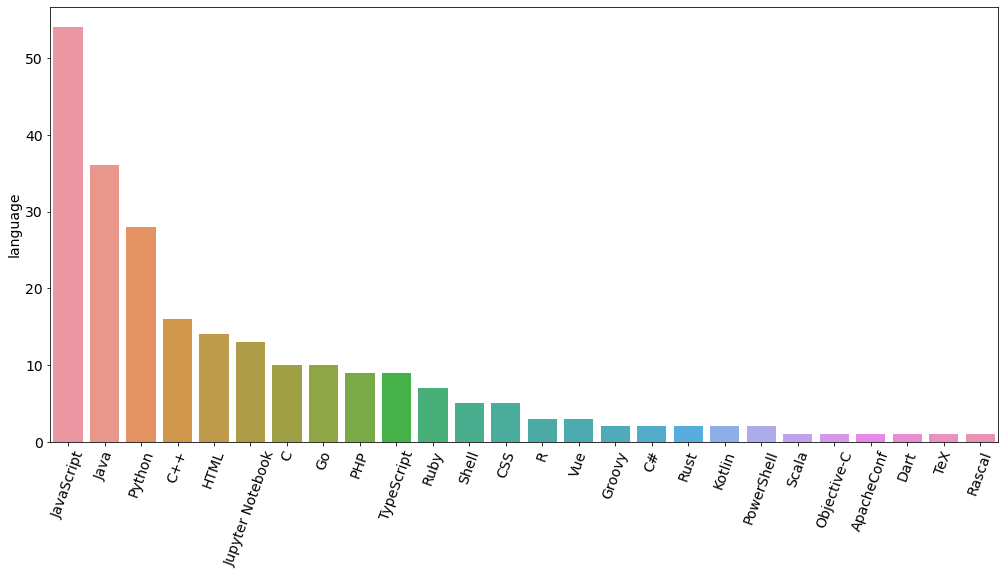

In [34]:
plt.figure(figsize=(17,8))
x = df_lang_count.index
y = df_lang_count.language
sns.barplot(data=df_lang_count, x=x, y=y)

plt.xticks(rotation=70)

## exploring words used

In [11]:
def clean(text: str) -> list:
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [12]:
df_clean = clean(' '.join(df.readme_contents))

In [13]:
df_clean

['share',
 'data',
 'statistician',
 'guide',
 'anyone',
 'need',
 'share',
 'data',
 'statistician',
 'data',
 'scientist',
 'target',
 'audience',
 'mind',
 'collaborator',
 'need',
 'statistician',
 'data',
 'scientist',
 'analyze',
 'data',
 'student',
 'postdoc',
 'various',
 'discipline',
 'looking',
 'consulting',
 'advice',
 'junior',
 'statistic',
 'student',
 'whose',
 'job',
 'collatecleanwrangle',
 'data',
 'set',
 'goal',
 'guide',
 'provide',
 'instruction',
 'best',
 'way',
 'share',
 'data',
 'avoid',
 'common',
 'pitfall',
 'source',
 'delay',
 'transition',
 'data',
 'collection',
 'data',
 'analysis',
 'leek',
 'grouphttpbiostatjhsphedujleek',
 'work',
 'large',
 'number',
 'collaborator',
 'number',
 'one',
 'source',
 'variation',
 'speed',
 'result',
 'status',
 'data',
 'arrive',
 'leek',
 'group',
 'based',
 'conversation',
 'statistician',
 'true',
 'nearly',
 'universally',
 'strong',
 'feeling',
 'statistician',
 'able',
 'handle',
 'data',
 'whatever',
 'sta

(-0.5, 1199.5, 899.5, -0.5)

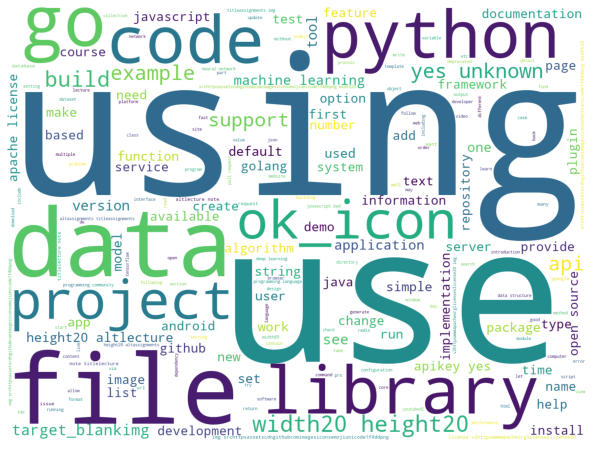

In [14]:
text = ' '.join(df_clean)
wc = WordCloud(background_color='white', width=1200, height=900)
img = wc.generate(text)

plt.imshow(img)
plt.axis('off')

## most common words in readme


In [15]:
common_words = pd.Series(df_clean).value_counts()
common_words.sort_values().tail(25)

system       506
language     519
see          523
machine      526
license      533
unknown      538
height20     549
width20      551
video        566
build        592
learning     618
note         630
ok_icon      633
yes          668
project      681
code         873
using        888
python       891
file         954
use          993
library     1055
go          1112
1           1197
img         1253
data        1345
dtype: int64

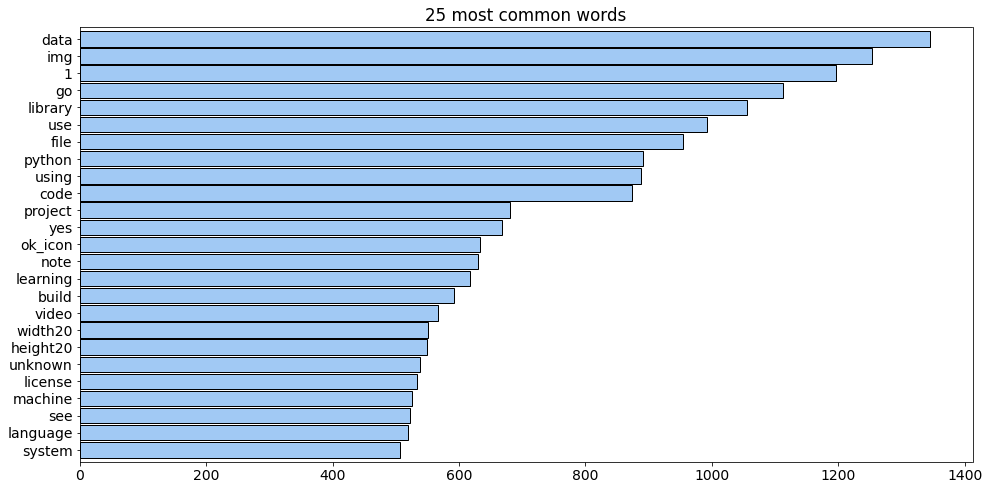

In [16]:
most_common_words = common_words.sort_values().tail(25)
most_common_words.drop(columns='all').plot.barh(width=.9, ec='black', title='25 most common words')

## Does the length of the README vary by programming language?

In [17]:
df2 = df[['language', 'readme_contents']]

In [18]:
df2['readme_contents'] = df2.readme_contents.apply(clean)

In [19]:
df2['length_of_readme'] = df2.readme_contents.apply(len)
df2.head()

,language,readme_contents,length_of_readme
0,None,"[share, data, statistician, guide, anyone, nee...",1061
1,R,"[introduction, second, programming, assignment...",332
2,HTML,"[well, hello, repository, meant, provide, exam...",60
3,C++,"[div, aligncenter, img, srchttpswwwtensorflowo...",430
4,Groovy,"[smartthings, public, github, repo, official, ...",32


> Scatter plot where length of readme is y-axis, x-axis is how many programming languages and hue is label of programming language

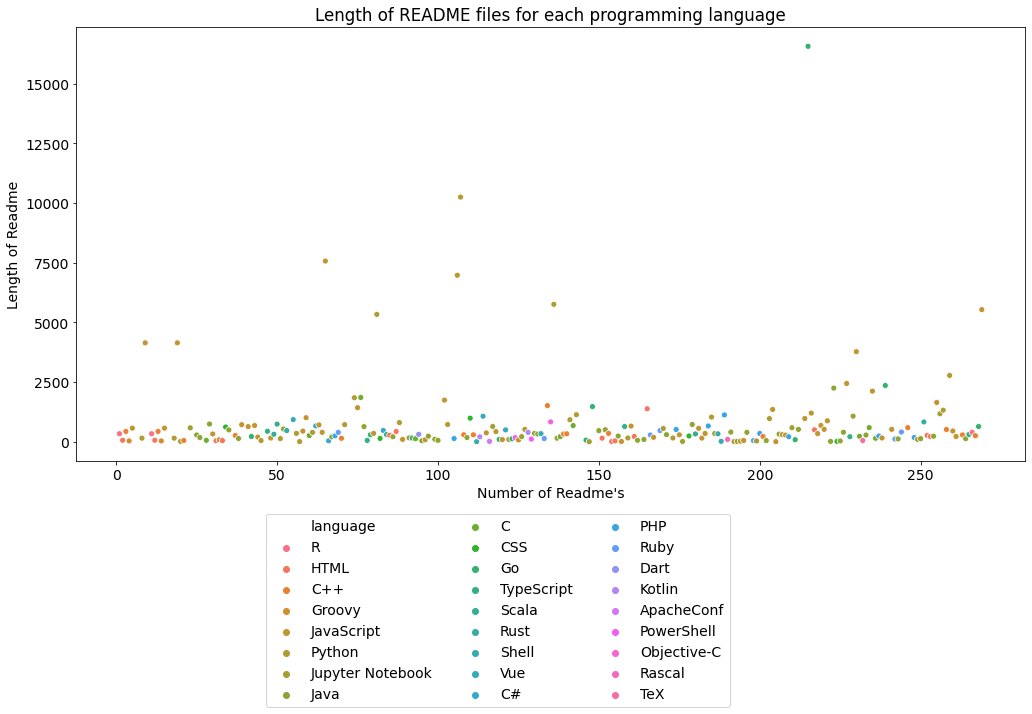

In [20]:
plt.figure(figsize=(17,8))
plt.title('Length of README files for each programming language')
x
x = df2.index
y = df2.length_of_readme
hue = df2.language
sns.scatterplot(data=df_lang_count, x=x, y=y, hue=hue)
plt.ylabel('Length of Readme')
plt.xlabel('Number of Readme\'s')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(0.2, -0.12), loc=2, borderaxespad=0., ncol=3)

plt.show()

## What does the distribution of IDFs look like for the most common words?


In [21]:
cv = CountVectorizer()
bag_of_words = cv.fit_transform(df_clean)

In [22]:
tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(df_clean)

In [23]:
s_1 = pd.Series(dict(zip(tfidf.get_feature_names(), tfidf.idf_))).sort_values()

In [24]:
df3 = pd.DataFrame(bag_of_words.todense(), columns=cv.get_feature_names()).T

In [25]:
s_1.sort_values()

data                                                      6.105509
img                                                       6.176307
go                                                        6.295587
library                                                   6.348158
use                                                       6.408664
                                                           ...    
readingshttpwwwececmueduece447s15dokuphpidreadings       12.617254
readingshttpsgroupscsailmitedumacusersgjs6945readings    12.617254
readingshttpphilipmjohnsongithubioics314f13readings      12.617254
readlinehttpsgithubcomchzyerreadline                     12.617254
zznam                                                    12.617254
Length: 48589, dtype: float64

### Do different programming languages use a different number of unique words?